In [76]:
%reload_ext autoreload
%autoreload 2

In [77]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [78]:

import os
import time
import warnings
from datetime import datetime, date
from pathlib import Path

import gymnasium as gym
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gymnasium import spaces
from IPython.display import clear_output
from scipy.special import erfc
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from tqdm import tqdm




BASE_PATH = "/Users/yc/Desktop"

# plot setting ------------------------
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

# colors
state_color = 'blue'
belief_color = 'purple'
eye_color = 'red'
cmap_eye = mcolors.LinearSegmentedColormap.from_list('eye_cmap', ['white', eye_color])
cmap_state = mcolors.LinearSegmentedColormap.from_list('state_cmap', ['white', state_color])
cmap_belief = mcolors.LinearSegmentedColormap.from_list('belief_cmap', ['white', belief_color])

In [79]:

class MouseNavigationEnv(gym.Env):
    """
    Mouse Navigation Environment with Left and Right Visual Areas.

    The mouse navigates a 2D arena to find the correct reward port based on
    accumulated left and right visual information, affected by observation noise.
    """

    def __init__(self, noise, info_matrix, nx=60, ny=50, max_v=4, i_threshold=20,
                 vcost=0.01, wcost=0.01, timecost=0.01, info_scale=1 / 20,
                 max_steps=100, reward_magnitude=1):
        super(MouseNavigationEnv, self).__init__()

        # Arena dimensions
        self.nx = nx
        self.ny = ny
        self.max_v = max_v
        self.i_threshold = i_threshold

        # Observation noise (standard deviation)
        self.noise = noise

        # Costs
        self.vcost = vcost
        self.wcost = wcost
        self.timecost = timecost
        self.info_scale = info_scale
        self.reward_magnitude = reward_magnitude

        self.info_matrix = info_matrix

        # Port locations
        self.left_port_x = 0
        self.right_port_x = nx - 1
        self.port_y = ny - 1

        # Correct port will be randomly selected in reset()
        self.correct_port_x = None

        # Maximum steps per episode
        self.max_steps = max_steps

        # Action space: Acceleration in x and y directions [-3, -2, -1, 0, 1, 2, 3]
        self.action_space = spaces.MultiDiscrete([7, 7])

        # Observation space: [x, y, vx, vy, left_info, right_info]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, -1, -1, -1]),
            high=np.array([1, 1, 1, 1, 1]), # normalize
            # high=np.array([nx - 1, ny - 1, max_v, max_v, 1]),
            dtype=np.float32
        )

        # Initialize state
        self.reset()

    def reset(self, seed=None, options=None):
        """Reset the environment to the starting state."""
        super().reset(seed=seed)

        # Start at the bottom center
        self.x = self.nx // 2
        self.y = 0

        # Start with zero velocity
        self.vx = 0
        self.vy = 0

        # Reset accumulated information
        self.cumulative_info = 0

        # Reset step counter
        self.steps = 0

        if options is not None:
            self.correct_port_x = options
        else:
            # Randomly select the correct port (left or right)
            self.correct_port_x = np.random.choice([self.left_port_x, self.right_port_x])

        # Current state
        self._update_state()

        return self.state, {}

    def _update_state(self):
        """Update the state vector."""
        if self.correct_port_x == 0:
            rewardp=self._success_prob_from_info(self.cumulative_info)*2-1
        else:
            rewardp=(self._success_prob_from_info(-self.cumulative_info)*2-1)*-1
        self.state = np.array([
            self.x/(self.nx-1), 
            self.y/(self.ny-1), 
            self.vx/self.max_v, 
            self.vy/self.max_v,
            rewardp
        ], dtype=np.float32)

    def _get_area_info_at_position(self, x, y, testing=False):
        """Get left and right area information at the given position with noise."""
        # Convert to integer indices and clip to bounds
        x_idx = max(0, min(int(x), self.nx - 1))
        y_idx = max(0, min(int(y), self.ny - 1))

        # Get raw values from matrices
        raw = self.info_matrix[x_idx, y_idx] * self.info_scale

        # Add observation noise. the noisy can be no info at all, or can by no noise (full info at the location)
        # we want: less info more chance to not observe anyything
        # noisy = (raw - np.max(self.info_matrix)/3*self.noise*(np.random.uniform(0, 1)))
        p=raw/np.max(self.info_matrix)
        noisy=(p-np.random.uniform(0, 1*self.noise))
        noisy = max(0, noisy)

        if testing:
            noisy = raw
        if self.correct_port_x == 0:
            return noisy
        else:
            return -noisy

    def _success_prob_from_info(self, info_val):
        """
        Calculate success probability based on accumulated left and right information.
        Higher difference between the correct choice and incorrect choice
        leads to higher success probability.
        """

        info_val = abs(info_val)

        # Use the erfc function: (1/2) * erfc(-sqrt(J/2))
        return 0.5 * erfc(-np.sqrt(info_val / 2))

    def step(self, action, testing=False):
        """
        Take a step in the environment based on the action.

        Args:
            action: [ax, ay] representing accelerations in x and y directions
                   Each element is in range [0, 6] which maps to [-3, -2, -1, 0, 1, 2, 3]

        Returns:
            (state, reward, done, truncated, info)
        """
        # Increment step counter
        self.steps += 1

        # Map action to acceleration
        ax = action[0]-3
        ay = action[1]-3
        # print(ax,ay)
        # Calculate next velocity
        next_vx = self.vx + ax
        next_vy = self.vy + ay
        # print(next_vx,next_vy)
        # Check velocity constraints
        speed = np.sqrt(next_vx**2 + next_vy**2)
        if speed >= self.max_v:
            # Scale down the velocity to max_v
            scaling_factor = (self.max_v - 0.1) / speed
            next_vx = next_vx * scaling_factor
            next_vy = next_vy * scaling_factor

        # Store old position for reward calculation
        old_x, old_y = self.x, self.y

        # Update position
        self.x += next_vx
        self.y += next_vy

        # Clip position to arena boundaries
        self.x = max(0, min(self.x, self.nx - 1))
        self.y = max(0, min(self.y, self.ny - 1))

        # Check if approaching a port and enforce horizontal approach
        approaching_port = (self.y >= self.port_y - abs(next_vy) and
                            (abs(self.x - self.left_port_x) <= abs(next_vx) or
                            abs(self.x - self.right_port_x) <= abs(next_vx)))

        if approaching_port:
            # Force horizontal approach by zeroing out vertical velocity
            self.vy = 0
        else:
            self.vy = next_vy

        self.vx = next_vx

        # Accumulate left and right information at current position
        info_gain = self._get_area_info_at_position(old_x, old_y, testing)
        self.cumulative_info += info_gain

        # Calculate costs
        velocity_cost = np.sqrt(self.vx**2 + self.vy**2) * self.vcost
        accel_cost = np.sqrt(ax**2 + ay**2) * self.wcost
        step_cost = -velocity_cost - accel_cost - self.timecost

        # Check if done
        at_left_port = (round(self.y) == self.port_y and round(self.x) == self.left_port_x)
        at_right_port = (round(self.y) == self.port_y and round(self.x) == self.right_port_x)
        at_port = at_left_port or at_right_port

        stopped = (abs(self.vx) < 0.01 and abs(self.vy) < 0.01 and self.steps > 1)
        reached_steps_limit = self.steps >= self.max_steps

        done = at_port or stopped or reached_steps_limit

        # Calculate reward
        reward = step_cost  # Always apply movement costs
        success_prob = self._success_prob_from_info(self.cumulative_info)
        if at_port:
            # Calculate success probability based on accumulated information
            

            # Check if the mouse chose the correct port
            correct_choice = ((at_left_port and self.correct_port_x == self.left_port_x) or
                              (at_right_port and self.correct_port_x == self.right_port_x))

            # Stochastically determine success based on accumulated information
            if correct_choice:
                # Success with probability based on accumulated info
                reward_outcome = success_prob * self.reward_magnitude
            else:
                # Failure with probability based on accumulated info (incorrect choice)
                # reward_outcome = 1 - success_prob*self.reward_magnitude
                reward_outcome = -success_prob * self.reward_magnitude*5

            reward += reward_outcome
        elif stopped:
            # Penalty for stopping without reaching a port
            reward -= 0.5 * self.reward_magnitude
        elif reached_steps_limit:
            # Small penalty for timeout
            reward -= 0.25 * self.reward_magnitude

        # if know which port, reward for going toward it
        # if success_prob>0.3:
        #     # print(success_prob, self.vx, np.sign(self.cumulative_info), success_prob*self.vx*np.sign(self.cumulative_info)*-1)
        #     away_punish=success_prob*self.vx*np.sign(self.cumulative_info)*-1*0.05
        #     reward+=min(0,away_punish)

        # Update state
        self._update_state()

        # Info dictionary for additional data
        info = {
            'position': (self.x, self.y),
            'velocity': (self.vx, self.vy),
            'cumulative_info': self.cumulative_info,
            'step_cost': step_cost,
            'at_port': at_port,
            'correct_port': 'left' if self.correct_port_x == self.left_port_x else 'right',
            'chosen_port': 'left' if at_left_port else ('right' if at_right_port else None),
            'success_prob': self._success_prob_from_info(
                self.cumulative_info
            ),
            'info_gain': info_gain,
        }

        return self.state, reward, done, False, info


# Function to visualize agent behavior with left-right areas
def visualize_agent(agent, env, info_matrix, num_episodes=1, test_noise=0):
    """
    Visualize a trained agent's behavior in the environment with left-right visual areas.

    Parameters:
        agent: The trained agent (e.g., a PPO model)
        env: The initialized environment
        info_matrix: The information matrix
        num_episodes: Number of episodes to run
        test_noise: Noise level for testing (override env.noise when set)
    """
    # Store original noise level to restore later
    original_noise = env.noise

    # Set noise to the test value if provided
    if test_noise is not None:
        env.noise = test_noise
        print(f"Testing with noise level: {env.noise}")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        for episode in range(num_episodes):
            # Reset environment
            obs, _ = env.reset(options=0)
            done = False

            # Track positions for trajectory
            positions_x = []
            positions_y = []
            info_values = []

            total_reward = 0

            # Run the episode
            while not done:
                # Get action from agent
                action, _ = agent.predict(obs, deterministic=True)

                # Execute action
                obs, reward, done, _, info = env.step(action, testing=True)
                total_reward += reward

                # Track position and information
                positions_x.append(info['position'][0])
                positions_y.append(info['position'][1])
                info_values.append(info['cumulative_info'])

            # Create first figure for trajectory
            plt.figure(figsize=(10, 8))

            plt.imshow(info_matrix.T, origin='lower')
            plt.colorbar(label='Information')

            # Plot trajectory with both line and dots
            plt.plot(positions_x, positions_y, 'k-o', alpha=0.7, linewidth=2, markersize=4)
            plt.scatter(positions_x[0], positions_y[0], color='blue', s=100, marker='o', label='Start')
            plt.scatter(positions_x[-1], positions_y[-1], color='blue', s=100, marker='x', label='End')

            # Plot ports
            plt.scatter(env.left_port_x, env.port_y, color='red', s=100, marker='s', label='Left port')
            plt.scatter(env.right_port_x, env.port_y, color='green', s=100, marker='s', label='Right port')
            plt.scatter(env.correct_port_x, env.port_y, color='yellow', s=150, marker='*', label='Correct port')

            # Add information
            final_info = info
            result = "Success" if final_info['chosen_port'] == final_info['correct_port'] else "Failure"
            if final_info['chosen_port'] is None:
                result = "Timeout/Stopped"

            plt.title(f"Episode {episode + 1} - {result}\n" +
                      f"Correct port: {final_info['correct_port']}, Chosen: {final_info['chosen_port']}, " +
                      f"cumulative info: {final_info['cumulative_info']:.2f}, Reward: {total_reward:.2f}" +
                      f"\nTesting with noise = {env.noise}")

            # the other port tajectry
            # Reset environment
            obs, _ = env.reset(options=59)
            done = False

            # Track positions for trajectory
            positions_x = []
            positions_y = []
            info_values = []

            total_reward = 0

            # Run the episode
            while not done:
                # Get action from agent
                action, _ = agent.predict(obs, deterministic=True)

                # Execute action
                obs, reward, done, _, info = env.step(action, testing=True)
                total_reward += reward

                # Track position and information
                positions_x.append(info['position'][0])
                positions_y.append(info['position'][1])
                info_values.append(info['cumulative_info'])
                # Plot trajectory with both line and dots
            plt.plot(positions_x, positions_y, 'k-o', alpha=0.7, linewidth=2, markersize=4)
            plt.scatter(positions_x[-1], positions_y[-1], color='blue', s=100, marker='x', label='End')

            plt.xlabel('X position')
            plt.ylabel('Y position')
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()

            # Create second figure for information accumulation
            plt.figure(figsize=(10, 6))

            # Plot information
            plt.plot(range(len(info_values)), info_values, 'b-', linewidth=2, label='Cumulative Info')

            # Add noise level reference
            # plt.axhline(y=env.noise, color='k', linestyle=':', alpha=0.7, label=f'Noise Level (σ={env.noise:.2f})')

            plt.title('Information Accumulation Over Time')
            plt.xlabel('Steps')
            plt.ylabel('Accumulated Information')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.show()

    # Restore original noise level
    env.noise = original_noise
    print(f"Restored original noise level: {original_noise}")



## testing

In [80]:
def visualize_agent_noise(agent, env, info_matrix, trials_per_condition=5, filename='testplot1'):
    """
    Visualize agent behavior with multiple trials per condition (left/right port).
    
    Parameters:
    - agent: The trained agent
    - env: The environment
    - info_matrix: Information matrix for visualization
    - num_episodes: Number of complete episodes to run
    - trials_per_condition: Number of trials to run for each condition (left/right)
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

    
        # Create lists to store trajectories for multiple trials
        left_trial_positions_x = []
        left_trial_positions_y = []
        left_trial_info_values = []
        left_trial_results = []
        left_trial_rewards = []
        left_trial_final_info = []
        
        right_trial_positions_x = []
        right_trial_positions_y = []
        right_trial_info_values = []
        right_trial_results = []
        right_trial_rewards = []
        right_trial_final_info = []
        
        # Run multiple left port trials
        for trial in range(trials_per_condition):
            # Reset environment for left port trial
            obs, _ = env.reset(options=0)
            # print(f"Left trial {trial+1}, correct port: {env.correct_port_x}")
            done = False

            # Track positions for this trial
            positions_x = []
            positions_y = []
            info_values = []
            total_reward = 0

            # Run the left trial
            while not done:
                # Get action from agent
                action, _ = agent.predict(obs, deterministic=True)

                # Execute action
                obs, reward, done, _, info = env.step(action)
                total_reward += reward
                # print(env.state, reward)
                
                # Track position and information
                positions_x.append(info['position'][0])
                positions_y.append(info['position'][1])
                info_values.append(info['cumulative_info'])
            
            # Convert to numpy arrays
            positions_x = np.array(positions_x)
            positions_y = np.array(positions_y)
            
            # Store this trial's data
            left_trial_positions_x.append(positions_x)
            left_trial_positions_y.append(positions_y)
            left_trial_info_values.append(info_values)
            left_trial_rewards.append(total_reward)
            left_trial_final_info.append(info)
            
            # Determine result
            result = "Success" if info['chosen_port'] == info['correct_port'] else "Failure"
            if info['chosen_port'] is None:
                result = "Timeout/Stopped"
            left_trial_results.append(result)
        
        # Run multiple right port trials
        for trial in range(trials_per_condition):
            # Reset environment for right port trial
            obs, _ = env.reset(options=59)
            # print(f"Right trial {trial+1}, correct port: {env.correct_port_x}")
            done = False

            # Track positions for this trial
            positions_x = []
            positions_y = []
            info_values = []
            total_reward = 0

            # Run the right trial
            while not done:
                # Get action from agent
                action, _ = agent.predict(obs, deterministic=True)

                # Execute action
                obs, reward, done, _, info = env.step(action)
                total_reward += reward
                # print(env.state, reward)
                
                # Track position and information
                positions_x.append(info['position'][0])
                positions_y.append(info['position'][1])
                info_values.append(info['cumulative_info'])
            
            # Convert to numpy arrays
            positions_x = np.array(positions_x)
            positions_y = np.array(positions_y)
            
            # Store this trial's data
            right_trial_positions_x.append(positions_x)
            right_trial_positions_y.append(positions_y)
            right_trial_info_values.append(info_values)
            right_trial_rewards.append(total_reward)
            right_trial_final_info.append(info)
            
            # Determine result
            result = "Success" if info['chosen_port'] == info['correct_port'] else "Failure"
            if info['chosen_port'] is None:
                result = "Timeout/Stopped"
            right_trial_results.append(result)

        # Create first figure for trajectories
        plt.figure(figsize=(10, 8))
        c=plt.imshow(info_matrix.T, origin='lower',cmap='grey')
        cbar=plt.colorbar(c, label='info gain')
        cbar.set_ticks([0, 20])
        cbar.set_ticklabels(['Low', 'High'])


        # Plot all left port trial trajectories
        for i, (positions_x, positions_y) in enumerate(zip(left_trial_positions_x, left_trial_positions_y)):
            # Offset each trial slightly for better visualization
            offset = 0.1 * (i - (trials_per_condition-1)/2)
            plt.plot(positions_x + offset, positions_y, 'b-o', alpha=0.5, linewidth=1.5, markersize=3)
            plt.scatter(positions_x[0], positions_y[0], color='blue', s=50, marker='o')
            plt.scatter(positions_x[-1], positions_y[-1], color='blue', s=50, marker='x')
        
        # Plot all right port trial trajectories
        for i, (positions_x, positions_y) in enumerate(zip(right_trial_positions_x, right_trial_positions_y)):
            # Offset each trial slightly for better visualization
            offset = 0.1 * (i - (trials_per_condition-1)/2)
            plt.plot(positions_x + offset, positions_y, 'r-o', alpha=0.5, linewidth=1.5, markersize=3)
            plt.scatter(positions_x[0], positions_y[0], color='red', s=50, marker='o')
            plt.scatter(positions_x[-1], positions_y[-1], color='red', s=50, marker='x')

        # Plot ports
        plt.scatter(env.left_port_x, env.port_y, color='red', s=100, marker='s', label='Left port')
        plt.scatter(env.right_port_x, env.port_y, color='green', s=100, marker='s', label='Right port')
        plt.scatter(env.correct_port_x, env.port_y, color='yellow', s=150, marker='*', label='Correct port')


        plt.xlabel('X position')
        plt.ylabel('Y position')
        plt.legend()
        # plt.grid(alpha=0.3)
        plt.savefig(f"{filename}_overhead.pdf", format="pdf", bbox_inches="tight")

        plt.xticks([0,59],['left','right'])
        plt.yticks([0,49],['backward','forward'])

        plt.show()
        # # Create second figure for information accumulation
        # plt.figure(figsize=(10, 6))

        # # Plot information for all left trials
        # for i, info_values in enumerate(left_trial_info_values):
        #     plt.plot(range(len(info_values)), info_values, 'b-', alpha=0.5, linewidth=1, 
        #                 label=f'Left Trial {i+1}' if i == 0 else None)
        
        # # Plot information for all right trials
        # for i, info_values in enumerate(right_trial_info_values):
        #     plt.plot(range(len(info_values)), info_values, 'r-', alpha=0.5, linewidth=1,
        #                 label=f'Right Trial {i+1}' if i == 0 else None)
        
        # # Plot average information curves
        # # First, find the maximum length among all trials
        # max_len = max([len(info) for info in left_trial_info_values + right_trial_info_values])
        
        # # Create arrays for averaging, padding shorter sequences
        # left_info_array = np.zeros((trials_per_condition, max_len))
        # right_info_array = np.zeros((trials_per_condition, max_len))
        
        # for i, info in enumerate(left_trial_info_values):
        #     left_info_array[i, :len(info)] = info
        #     # For unused elements, repeat the last value (to avoid affecting the average)
        #     if len(info) < max_len:
        #         left_info_array[i, len(info):] = info[-1]
        
        # for i, info in enumerate(right_trial_info_values):
        #     right_info_array[i, :len(info)] = info
        #     # For unused elements, repeat the last value
        #     if len(info) < max_len:
        #         right_info_array[i, len(info):] = info[-1]
        
        # # Calculate means
        # left_mean = np.mean(left_info_array, axis=0)
        # right_mean = np.mean(right_info_array, axis=0)
        
        # # Plot means with thicker lines
        # plt.plot(range(max_len), left_mean, 'b-', linewidth=3, label='Left Trials Mean')
        # plt.plot(range(max_len), right_mean, 'r-', linewidth=3, label='Right Trials Mean')

        # plt.title('Information Accumulation Over Time - Multiple Trials')
        # plt.xlabel('Steps')
        # plt.ylabel('Accumulated Information')
        # plt.grid(True, alpha=0.3)
        # plt.legend()
        # plt.show()

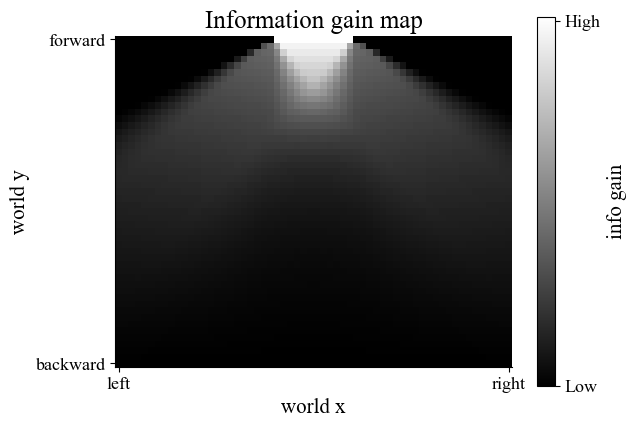

Model laoded with ./mouse_navigation_modelw6


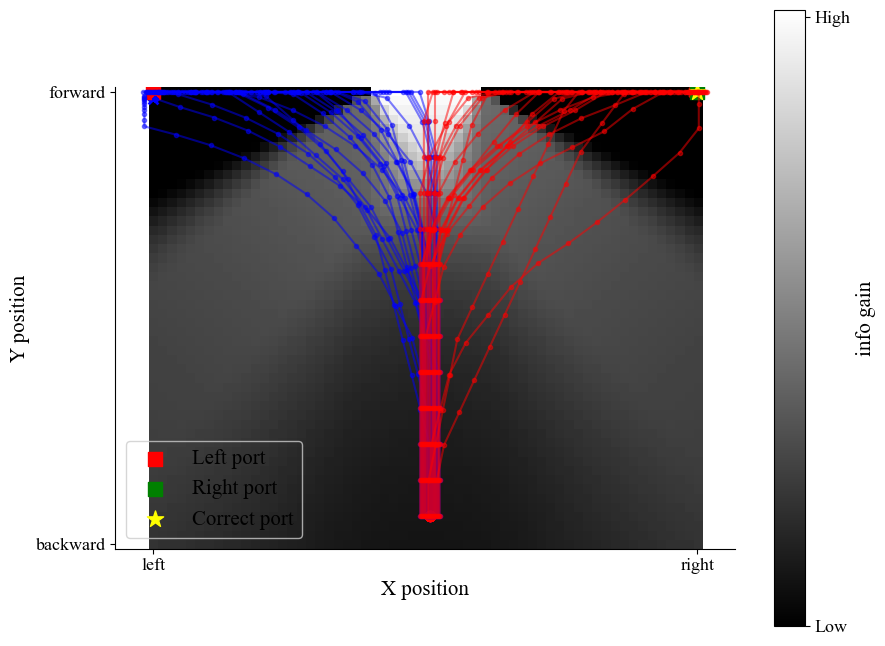

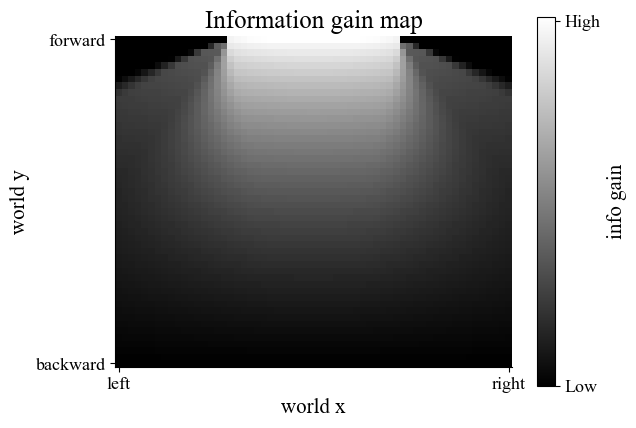

Model laoded with ./mouse_navigation_modelw13


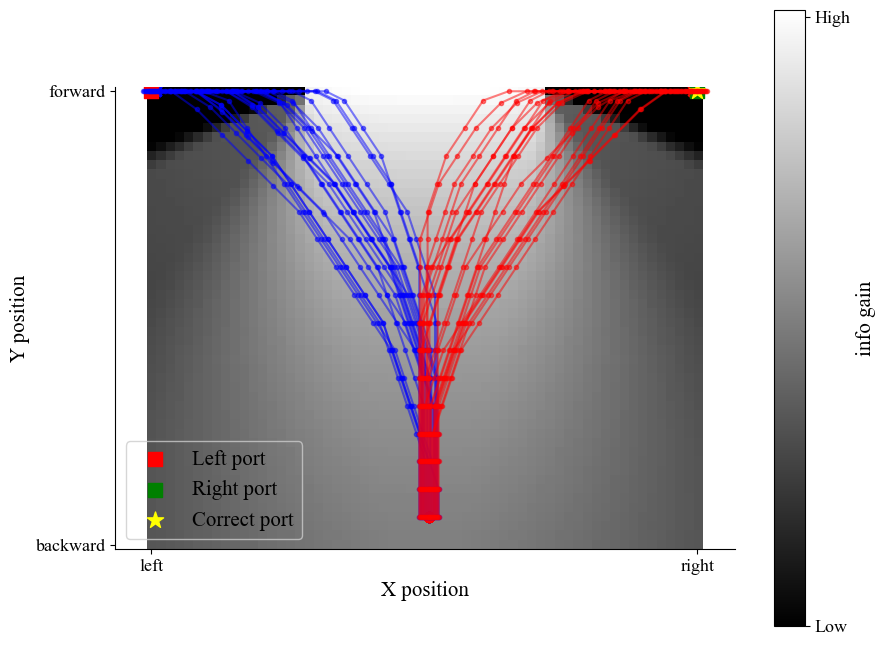

In [81]:
for gap_width in [6,13]:

    port_reward=1
    info_matrix=np.load(f'new_info_matrix_hres_{gap_width}.npy')[:,:-10]
    mask = np.ones_like(info_matrix)
    gradient = np.linspace(0.0, 1., info_matrix.shape[1])
    for i in range(info_matrix.shape[1]):
        mask[:, i] = gradient[i]
    # Apply the mask to darken the bottom gradually
    masked_info_matrix = info_matrix * mask
    plt.xlabel('world x')
    plt.ylabel('world y')
    plt.title('Information gain map')
    c= plt.imshow(masked_info_matrix.T,origin='lower', cmap='grey')
    cbar=plt.colorbar(c, label='info gain')
    cbar.set_ticks([0, 20])
    cbar.set_ticklabels(['Low', 'High'])
    plt.xticks([0,59],['left','right'])
    plt.yticks([0,49],['backward','forward'])
    plt.savefig(f"aperture_{gap_width}_infomap.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    # Create environment
    env = MouseNavigationEnv(
        info_matrix=info_matrix,
        nx=60, ny=50, max_v=4, i_threshold=5, 
        noise=0.3, 
        vcost=0.01, 
        wcost=0.01, 
        timecost=0.001, 
        info_scale=0.3,
        max_steps=200, 
        reward_magnitude=3
    )

    model_path = f"./mouse_navigation_modelw{gap_width}"
    print(f"Model laoded with {model_path}")
    model = PPO.load(model_path)  # Replace PPO with your algorithm


    # visualize_agent(model, env, info_matrix, num_episodes=1)
    visualize_agent_noise(model, env, info_matrix, trials_per_condition=22,filename=f'aperture_{gap_width}')
